In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import attrgetter

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
orderitems = pd.read_csv('olist_order_items_dataset.csv')

Построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

R - время от последней покупки пользователя до текущей даты.
F - суммарное количество покупок у пользователя за всё время.
M - сумма покупок за всё время.

Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.


# Решение по шагам:

1) Считаем R.

2) Считаем F.

3) Считаем M.

4) Мерджим данные по R, F и М в датафрейм rfm.

5) Написал функцию, присваивающую оценку каждой метрике пользователя.

6) Создал колонку 'rfm_score'.

7) Разбил пользователей на категории.

Extra. Сделал визуализацию по категориям пользователей.

# Шаг №1. Считаем R.

R - время от последней покупки пользователя до текущей даты.

Я замерджил датафреймы customers и orders по 'customer_id'. Полученный датафрейм назвал task_r.

Нашел время самого последнего заказа с помощью max() ('last_order'). 

In [48]:
# Замерджил датафреймы customers и orders по 'customer_id'.
task_r = customers.merge(orders, on = 'customer_id')
# Нашел время самого последнего заказа с помощью max(). 
task_r['order_purchase_timestamp'] = pd.to_datetime(task_r['order_purchase_timestamp'])
last_order = task_r.order_purchase_timestamp.max()
last_order

Timestamp('2018-10-17 17:30:18')

Выяснил разницу в днях между самым последним заказом и последним заказом каждого уникального пользователя,вычислив из датафрейма last_order дату последнего заказа каждого пользователя. Эту разницу для каждого пользователя я занес в колонку 'time_from_last_order', а после перевел в формат дней.

In [49]:
# Вычисляем дату последнего заказа каждого пользователя.
task_r = task_r.groupby('customer_unique_id').agg({'order_purchase_timestamp': 'max'})
# Вычисляем разницу между самым последним заказом и последним заказом каждого пользователя.
task_r['time_from_last_order'] = last_order - task_r.order_purchase_timestamp
task_r['time_from_last_order'] = task_r['time_from_last_order'].dt.days
task_r = task_r.sort_values('time_from_last_order')
task_r.head(3)

,order_purchase_timestamp,time_from_last_order
customer_unique_id,,
87ab9fec999db8bd5774917de3cdf01c,2018-10-17 17:30:18,0
262e1f1e26e92e86375f86840b4ffd63,2018-10-16 20:16:02,0
af5454198a97379394cacf676e1e96cb,2018-10-03 18:55:29,13


# Шаг №2. Считаем F.

F - суммарное количество покупок у пользователя за всё время.

Замерджил датафреймы customers и orders по 'customer_id'. Полученный датафрейм назвал task_f.

После я посчитал суммарное количество покупок у каждого уникального пользователя за всё время.

In [50]:
# Мерджим датафреймы customers и orders по 'customer_id'.
task_f = customers.merge(orders, on = 'customer_id')
# Считаем суммарное количество покупок у каждого уникального пользователя за всё время.
task_f = task_f.groupby('customer_unique_id')\
    .agg({'order_id': 'count'})\
    .sort_values('order_id', ascending = False)
task_f.head(3)

,order_id
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
6469f99c1f9dfae7733b25662e7f1782,7


# Шаг №3. Считаем M.

M - сумма покупок за всё время.

Выяснил сколько стоила каждая покупка и сохранил данные в m_items.

Сделал мердж m_items с orders по 'order_id'.

Выяснил сколько стоила каждый заказ (m_merge).

Сделал мердж m_merge с orders по 'customer_id'.

Выяснил сколько денег принес каждый уникальный пользователь (task_m).

In [51]:
# Выяснил сколько стоила каждая покупка.
m_items = orderitems.groupby(['order_id', 'product_id'], as_index = False).agg({'price': 'sum'})\
    .groupby('order_id').agg({'price': 'sum'})
m_items.head(3)

,price
order_id,
00010242fe8c5a6d1ba2dd792cb16214,58.9
00018f77f2f0320c557190d7a144bdd3,239.9
000229ec398224ef6ca0657da4fc703e,199.0


In [52]:
# Сделал мердж m_items с orders по 'order_id'.
m_merge = m_items.merge(orders, how='right', on='order_id')
# Выяснил сколько стоила каждый заказ
m_merge = m_merge.groupby('customer_id').agg({'price': 'sum'})
m_merge.head(3)

,price
customer_id,
00012a2ce6f8dcda20d059ce98491703,89.80
000161a058600d5901f007fab4c27140,54.90
0001fd6190edaaf884bcaf3d49edf079,179.99


In [53]:
# Сделал мердж m_merge с orders по 'customer_id'.
task_m = m_merge.merge(customers, how='inner', on='customer_id')
# Выяснил сколько денег принес каждый уникальный пользователь.
task_m = task_m.groupby('customer_unique_id').agg({'price': 'sum'})
task_m.head(3)

,price
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.9
0000b849f77a49e4a4ce2b2a4ca5be3f,18.9
0000f46a3911fa3c0805444483337064,69.0


Проверил, что ничего не потерял перед мерджем.

In [54]:
(task_f.sort_values('customer_unique_id').reset_index().customer_unique_id == task_m.sort_values('customer_unique_id').reset_index().customer_unique_id)\
    .value_counts()

True    96096
Name: customer_unique_id, dtype: int64

Проверил, что ничего не потерял перед мерджем х2.

In [55]:
(task_m.sort_values('customer_unique_id').reset_index().customer_unique_id == task_r.sort_values('customer_unique_id').reset_index().customer_unique_id)\
    .value_counts()

True    96096
Name: customer_unique_id, dtype: int64

# Шаг №4. Создаем датафрейм rfm.

Я соединил данные по R, F и М в один датафрейм (rfm).

In [56]:
task_r = task_r.merge(task_f, how='left', on='customer_unique_id').merge(task_m, how='left', on='customer_unique_id')
task_r = task_r[['time_from_last_order', 'order_id', 'price']]
rfm = pd.DataFrame
rfm = task_r
# Для удобства переименовываю колнки.
rfm = rfm.rename(columns={'time_from_last_order': 'recency', 'order_id': 'frequency', 'price': 'monetary'})
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
87ab9fec999db8bd5774917de3cdf01c,0,1,0.0
262e1f1e26e92e86375f86840b4ffd63,0,2,197.5
af5454198a97379394cacf676e1e96cb,13,3,178.0
634420a0ea42302205032ed44ac7fccc,16,2,65.0
9bb92bebd4cb7511e1a02d5e50bc4655,18,1,0.0


# Шаг №5. Пишем функции, присваивающие оценку каждой метрике пользователя.

# R
По данной метрике можно было получить оценку от 1 до 5 в зависимости от того, насколько давно пользователь делал последнюю покупку.

Оценка давалась исходя из сравнения 'recency' пользователя с перцентилем 'recency' всех пользователей.

Чем больше оказывалось 'recency', тем меньше получался итоговый балл.

# M
По данной метрике можно было получить оценку от 1 до 5 в зависимости от размера дохода, который принес пользователь.

Оценка давалась исходя из сравнения 'monetary' пользователя с перцентилем 'monetary' всех пользователей.

Чем больше оказывалось 'monetary', тем больше получался итоговый балл.    

# F
Перцентили не использовались для дачи оценки, так как подавляющее большинство пользователей сделали одну покупку. 

Использовав функцию 'value_counts()', я выяснил какие 'frequency' встречаются в массиве и определил систему оценивания.

По данной метрике можно было получить оценку от 1 до 2 в зависимости от частоты покупок пользователя.

- 1 получали те, кто сделал одну покупку.

- 2 получали те, кто вернулся после первой покупки.

In [57]:
def r_score(x):
    if x >= rfm.recency.quantile(0.8):
        return 1
    elif x >= rfm.recency.quantile(0.6):
        return 2
    elif x >= rfm.recency.quantile(0.4):
        return 3
    elif x >= rfm.recency.quantile(0.2):
        return 4
    else:
        return 5 

def m_score(x):
    if x <= rfm.monetary.quantile(0.2):
        return 1
    elif x <= rfm.monetary.quantile(0.4):
        return 2
    elif x <= rfm.monetary.quantile(0.6):
        return 3
    elif x <= rfm.monetary.quantile(0.8):
        return 4
    else:
        return 5

def f_score(x):
    if x == 1:
        return 1
    elif x >= 2:
        return 2

# "...какие 'frequency' встречаются в массиве..."
rfm.frequency.value_counts().sort_values()

17        1
9         1
7         3
6         6
5         8
4        30
3       203
2      2745
1     93099
Name: frequency, dtype: int64

Далее я создал колнки для R, F, M, применив соответствующие функции к датафрейму rfm.

In [58]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))

In [59]:
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))

In [60]:
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

# Шаг №6. Cоздаем колнку 'rfm_score'.

'rfm_score' в дальнейшем позволит мне присвоить каждому пользователю подходящий ранг. 

In [61]:
rfm['rfm_score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

# Шаг №7. Присваиваем ранг каждому пользователю.

Каждый пользователь будет отнесен к своему сегменту в зависимости от своих показателей R и F. Ниже в segt_map можно поближе познакомиться с моей системой рангов.

Сегмент пользователя будет показываться в колонке 'segment' в датафрейме rfm.

In [62]:
segt_map = {
    r'[1-2]1': 'hibernating',
    r'[1-2]2': 'at risk',
    r'31': 'about to sleep',
    r'32': 'need attention',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2]': 'loyal customers',
}

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)
answer_6 = rfm

In [63]:
# Ответ на задачу №6.
answer_6.head()

,recency,frequency,monetary,R,F,M,rfm_score,segment
customer_unique_id,,,,,,,,
87ab9fec999db8bd5774917de3cdf01c,0,1,0.0,5,1,1,511,new customers
262e1f1e26e92e86375f86840b4ffd63,0,2,197.5,5,2,5,525,loyal customers
af5454198a97379394cacf676e1e96cb,13,3,178.0,5,2,4,524,loyal customers
634420a0ea42302205032ed44ac7fccc,16,2,65.0,5,2,2,522,loyal customers
9bb92bebd4cb7511e1a02d5e50bc4655,18,1,0.0,5,1,1,511,new customers


# Extra

Для быстрого анализа rfm-сегментов я построил три визуализации.

# Extra 1. 

Я отразил разницу в количестве пользователей между всеми категориями.

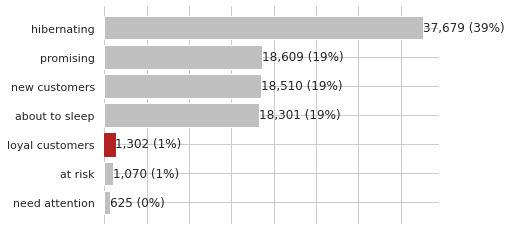

In [64]:
# Extra 1.
task_6_viz_1 = rfm
segments_counts = task_6_viz_1['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

# Extra 2.

Я отразил разницу в количестве пользователей между категориями с высокой F-оценкой. На данной визуализацции заметно, что у анализируемого e-commerce имеется небольшая группа лояльных покупателей, которые стабильно возвращаются в наш магазин.

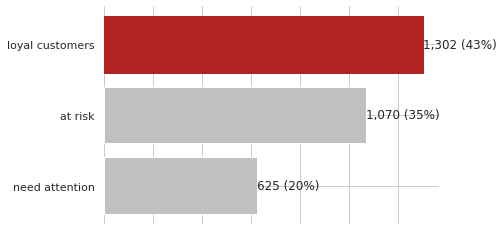

In [65]:
task_6_viz_2 = rfm.query("segment == 'loyal customers' or segment == 'at risk' or segment == 'need attention'")
segments_counts = task_6_viz_2['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

# Extra 3.
Я решил построить pieplot, чтобы выяснить, приносит ли группа лояльных пользователей ощутимый доход относительно остальных. Полученный результат показывает, что лояльные пользователи (по моим критериям) не являются основным источником дохода.

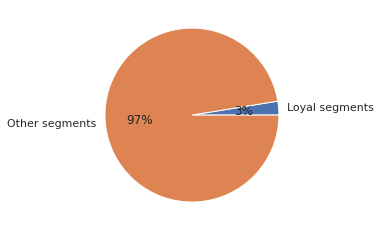

In [66]:
rfm_extra_1 = rfm.query("segment == 'loyal customers'").groupby('segment').agg({'monetary': 'sum'})
rfm_extra_2 = rfm.query("segment != 'loyal customers'").groupby('segment').agg({'monetary': 'sum'})
pie_6 = []
pie_6.append(rfm_extra_1.monetary.sum())
pie_6.append(rfm_extra_2.monetary.sum())
plt.pie(pie_6, labels = ['Loyal segments', 'Other segments'], autopct='%.0f%%')
plt.show()